In [1]:
## GHRC MRMS data
# http link and S3 link

In [2]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# # add path to environment in case of plot error
# import os
# os.environ['PROJ_LIB']=r'/home/user/.conda/envs/venvname/share/proj' # path to the proj4 folder.
# os.environ['GDAL_DATA']=r'/home/user/.conda/envs/venvname/share' # path to the proj4 folder.

# Direct access
# import s3fs
import earthaccess as ea
import fsspec

# datetime
import datetime as dt

# api to read files: possible packages to use
# import xarray as xr # for netcdf
# import h5py  # for hdf5
import gzip  # for .gz to decompress the file

# data process
import numpy as np
import pandas as pd

# plotting using self-defined functions for better visualization
from plot_function import ndarry_mask  # mask the array
from plot_function import map_plot  # plot the map
import matplotlib.pyplot as plt


In [3]:
# For example, if you want to print the structure of a HDF5 file you can use the following code:
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

In [4]:
auth = ea.login(strategy="netrc", persist=True) # use 'interactive' strategy the first time to log in

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 11/10/2023
Using .netrc file for EDL


In [5]:
#### dataset2 in ASCII format with compression ####

# step1: provdie the daac name and short name of dataset
    # define the name of daac and dataset
DAAC2 = 'GHRC_DAAC'
ssh_short_name2 = "gpmmrms" # short name of dataset. 

# step2: get links #
results2 = ea.search_data(
    short_name=ssh_short_name2,
    cloud_hosted=True,
    temporal=("2015-05-16", "2015-05-17"),
)

    # data_link list
https_links2 = []  # external link, todo: find ways to directly access data using external link
s3_links2 = []  # s3 link to directly accessing  data in AWS

for granule in results2:
    https_links2.extend(granule.data_links(access="on_prem"))
    s3_links2.extend(granule.data_links(access="direct"))
    
# step3: select proper links for use (similar part to what we did when we worked in local enviroment)


Granules found: 76


In [6]:
# s3_fs2 = ea.get_s3fs_session(DAAC2)  # failed to get the credential. It's better to provide daac code to ensure that the variable name is correct to get the credential.
ea.daac

<module 'earthaccess.daac' from '/srv/conda/envs/notebook/lib/python3.10/site-packages/earthaccess/daac.py'>

In [7]:
https_links2[58]
#s3_links2

'https://data.ghrc.earthdata.nasa.gov/ghrcw-protected/gpmmrms__1/mrms_PRECIPRATE_GC_20150516_164400_6893.dat.gz'

In [8]:
# step4: for S3, get credentials and open files with credentials #
s3_fs2 = ea.get_fsspec_https_session() 

#### read data under zip file (.gz)####
# open files with https links, works both in and out AWS #
with s3_fs2.open(https_links2[58], mode='rb') as f2: # open files with https links: 4:44pm
    with gzip.open(f2, 'rb') as data_ori:  # decompress .gz files
        ascii_grid = np.loadtxt(data_ori,skiprows = 6)  # read interested dataset
        
with s3_fs2.open(https_links2[58], mode='rb') as f2: # open files with https links
    with gzip.open(f2, 'rb') as data_ori:  # decompress .gz files
        datainfo = pd.read_csv(data_ori, header=None)[:6]  # read coordinate information
        coor_info = datainfo.iloc[0:6, 0].str.split(' ', expand=True) # split coordinate information

In [9]:
ascii_grid.shape

(3500, 7000)

In [10]:
coor_info

,0,1
0,ncols,7000
1,nrows,3500
2,xllcenter,-129.995000
3,yllcenter,20.005000
4,cellsize,0.010000
5,NODATA_value,-999


Errors might occur if we read the information in the same opened file:

In [11]:
with s3_fs2.open(https_links2[58], mode='rb') as f2:  # open files with https links
    with gzip.open(f2, 'rb') as data_ori:  # decompress .gz files
        datainfo = pd.read_csv(data_ori, header=None)[:6]  # read coordinate information
        ascii_test = np.loadtxt(data_ori, skiprows=6)  # read interested dataset  

In [12]:
ascii_test  # no data was read

array([], dtype=float64)

Plot the data

In [13]:
# get the coordinate information
x0 = float(coor_info.iloc[2, 1])
xn = x0 + (float(ascii_grid.shape[1])-1) * float(coor_info.iloc[4, 1])
x_coor = np.round(np.linspace(np.round(x0,2),np.round(xn,2),ascii_grid.shape[1]),2)

y0 = float(coor_info.iloc[3, 1])+ (float(ascii_grid.shape[0])-1) * float(coor_info.iloc[4, 1])
yn = y0 - (float(ascii_grid.shape[0])-1) * float(coor_info.iloc[4, 1])
y_coor = np.round(np.linspace(np.round(y0,2),np.round(yn,2),ascii_grid.shape[0]),2)
# print(y_coor)
# print(x_coor)

In [14]:
# replace -999. and 0 with nan
ascii_grid[ascii_grid == -999.] = np.nan
ascii_grid[ascii_grid == 0.] = np.nan

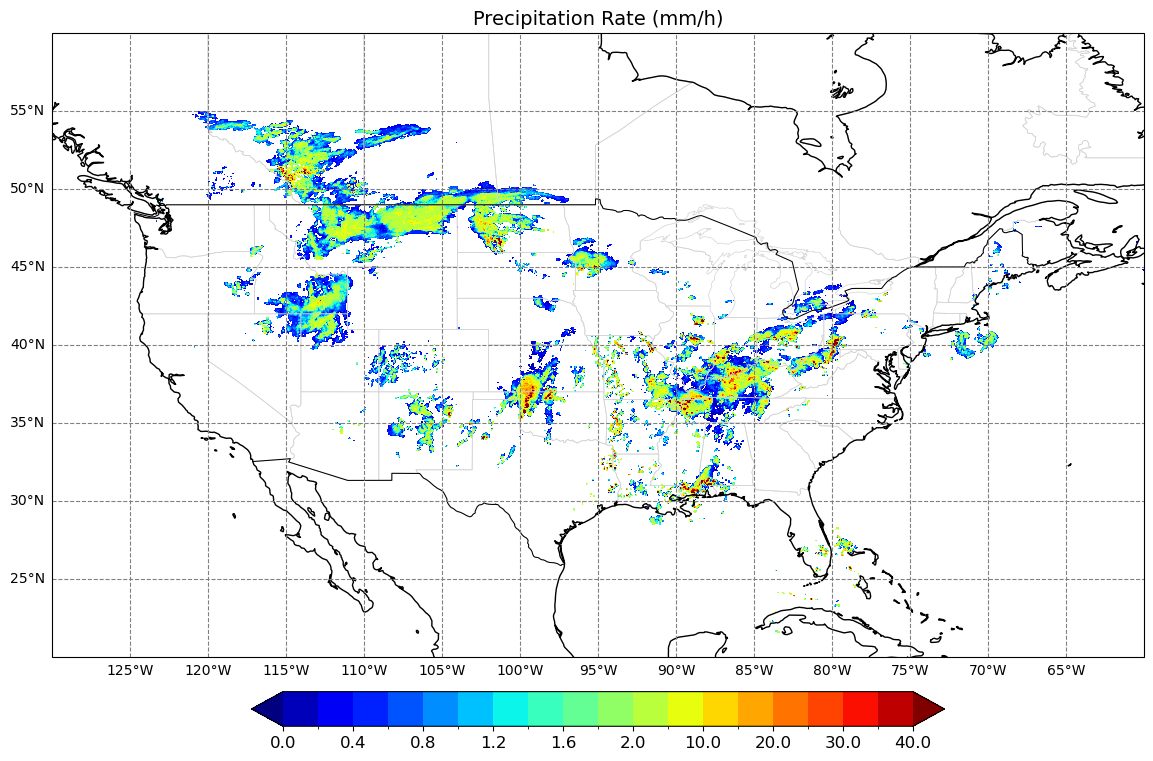

In [15]:
# plot the data
# data_masked = ndarry_mask(x_coor, y_coor, ascii_grid, country_point=[-98.5, 39.8])  # flip the mask to match the data
data_masked = ascii_grid
bounds = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 5, 10, 15, 20, 25, 30, 35, 40]
c_map = 'jet'

fig1, main_ax1, cbar1 = map_plot(x_coor, y_coor, data_masked, zoom_region=[x0, xn, y0, yn], bounds=bounds, c_map=c_map)
main_ax1.set_title('Precipitation Rate (mm/h)', fontsize=14)
plt.show()